In [1]:
from skimage import feature
from imutils import paths
import numpy as np
import argparse
import cv2 as cv
import os
import pandas as pd
from google.colab.patches import cv2_imshow
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score, precision_score, recall_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB,BernoulliNB,CategoricalNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb
from imutils import build_montages

In [2]:
def preprocess(image, image_size=128):
	image = cv.cvtColor(image, cv.COLOR_BGR2GRAY) # Ubah mehjadi grayscale
	image = cv.resize(image, (image_size, image_size)) # Resize gambar menjadi suatu ukuran (default = 128)
	image = cv.threshold(image, 0, 255, cv.THRESH_BINARY_INV | cv.THRESH_OTSU)[1] # Melakukan thresholding dan mengambil hasil gambar thresholding
	return image

def quantify_image_hog(image): # Histogram of Oriented Gradient features
	features = feature.hog(image, orientations=9, pixels_per_cell=(10, 10), cells_per_block=(2, 2), transform_sqrt=True, block_norm="L1")
	return features

def quantify_image_lbp(image): # Local Binary Pattern features
  features = feature.local_binary_pattern(image, 24, 8, method="uniform")
  (hist, _) = np.histogram(features.flatten(), bins=np.arange(0, 27), range=(0, 26))
  hist = hist.astype("float")
  hist /= (hist.sum() + 1e-7)
  return hist

def load_split(path, image_size=128, extraction_method='hog'):
	image_paths = list(paths.list_images(path))
	data = []
	labels = []

	for image_path in image_paths:
		label = image_path.split(os.path.sep)[-2]

		image = cv.imread(image_path)
		image = preprocess(image, image_size=image_size)
		
		if extraction_method == 'hog':
			features = quantify_image_hog(image)
		elif extraction_method == 'lbp':
			features = quantify_image_lbp(image)
   
		data.append(features)
		labels.append(label)
	return (np.array(data), np.array(labels))
 
def linear_classifier(feature_train,feature_test,label_train,label_test):
  linear_class = LinearSVC(random_state=10)
  linear_class.fit(feature_train, label_train)
  predictions = linear_class.predict(feature_test)

  print(classification_report(label_test, predictions))
  print('Accuracy of linear_classifier on test set: {:.2f}'.format(linear_class.score(feature_test, label_test))) # .score() -> Accuracy
  print("F1", f1_score(label_test, predictions, average="macro"))
  print("Precision", precision_score(label_test, predictions, average="macro"))
  print("Recall", recall_score(label_test, predictions, average="macro"),"\n")
  return

def logreg_classifier(feature_train,feature_test,label_train,label_test):
  logreg_class = LogisticRegression()
  logreg_class.fit(feature_train, label_train)
  predictions = logreg_class.predict(feature_test)

  print(classification_report(label_test, predictions))
  print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg_class.score(feature_test, label_test))) # .score() -> Accuracy
  print("F1", f1_score(label_test, predictions, average="macro"))
  print("Precision", precision_score(label_test, predictions, average="macro"))
  print("Recall", recall_score(label_test, predictions, average="macro"),"\n")
  return

def RandomF_classifier(feature_train,feature_test,label_train,label_test):
  Random_class = RandomForestClassifier(n_estimators=100, random_state=10)
  Random_class.fit(feature_train, label_train)
  predictions = Random_class.predict(feature_test)

  print(classification_report(label_test, predictions))
  print('Accuracy of Random_Forest_classifier on test set: {:.2f}'.format(Random_class.score(feature_test, label_test))) # .score() -> Accuracy
  print("F1", f1_score(label_test, predictions, average="macro"))
  print("Precision", precision_score(label_test, predictions, average="macro"))
  print("Recall", recall_score(label_test, predictions, average="macro"),"\n")
  return 

def Classifier(feature_train,feature_test,label_train,label_test):
  algoritma=[RandomForestClassifier,KNeighborsClassifier,SVC,LinearSVC,GaussianNB,BernoulliNB,LogisticRegression,
             LinearDiscriminantAnalysis,DecisionTreeClassifier,xgb.XGBClassifier]
  
  for index,value in enumerate(algoritma):
    if value == RandomForestClassifier:
      classifier = value(bootstrap=True, max_features = "sqrt",n_estimators=100,random_state=10)
      classifier.fit(feature_train, label_train)
    elif value == KNeighborsClassifier:
      classifier = value(11)
      classifier.fit(feature_train, label_train)
    elif value == SVC:
      kernels=["linear","poly","rbf"]
      for index,value_ker in enumerate(kernels):
        svc_classifier = SVC(kernel = value_ker)
        svc_classifier.fit(feature_train, label_train)
        # prediction
        prediction = svc_classifier.predict(feature_test)
        #hasil
        print(classification_report(label_test, prediction))
        print('Accuracy of SVC with Kernel {} on test set: {:.2f}'.format(value_ker,svc_classifier.score(feature_test, label_test))) # .score() -> Accuracy
        print(f1_score(label_test, prediction, average='macro'))
        print(precision_score(label_test, prediction, average='macro'))
        print(recall_score(label_test, prediction, average='macro'),'\n')
      continue
    elif value == xgb.XGBClassifier:
      classifier = value(learning_rate=0.1)
      classifier.fit(feature_train, label_train)
    else:
      classifier = value()
      classifier.fit(feature_train, label_train)
  
    # prediction
    prediction = classifier.predict(feature_test)
    #hasil
    print(classification_report(label_test, prediction))
    print('Accuracy of {} on test set: {:.2f}'.format(value,classifier.score(feature_test, label_test))) # .score() -> Accuracy
    print(f1_score(label_test, prediction, average='macro'))
    print(precision_score(label_test, prediction, average='macro'))
    print(recall_score(label_test, prediction, average='macro'),'\n')
  return 


# **Data Testing Bawaan**

In [3]:
dataset_dir = '/content/drive/My Drive/BCML/foto/number'

trainingPath = os.path.join(dataset_dir, "training")
testingPath = os.path.join(dataset_dir, "testing")

resize_image_size = 28 
extraction_method = 'hog'

(feature_train, label_train) = load_split(trainingPath, image_size=resize_image_size, extraction_method=extraction_method)
(feature_test, label_test) = load_split(testingPath, image_size=resize_image_size, extraction_method=extraction_method)

le = LabelEncoder()
label_train = le.fit_transform(label_train)
label_test = le.transform(label_test)

# print(feature_train)
# print(feature_test)
# print(label_train)
# print(label_test)

print("Data berhasil didapat!")

Data berhasil didapat!


In [4]:
Classifier(feature_train,feature_test,label_train,label_test)

              precision    recall  f1-score   support

           0       0.97      0.98      0.98       300
           1       0.99      0.98      0.99       300
           2       0.98      0.98      0.98       300

    accuracy                           0.98       900
   macro avg       0.98      0.98      0.98       900
weighted avg       0.98      0.98      0.98       900

Accuracy of <class 'sklearn.ensemble._forest.RandomForestClassifier'> on test set: 0.98
0.9822331976528135
0.9822587176714026
0.9822222222222222 

              precision    recall  f1-score   support

           0       0.98      0.97      0.98       300
           1       0.97      0.99      0.98       300
           2       0.99      0.98      0.99       300

    accuracy                           0.98       900
   macro avg       0.98      0.98      0.98       900
weighted avg       0.98      0.98      0.98       900

Accuracy of <class 'sklearn.neighbors._classification.KNeighborsClassifier'> on test set: 0

In [54]:
testing_paths = list(paths.list_images(testingPath))
images = []
svc_class = SVC(kernel='rbf')
svc_class.fit(feature_train, label_train)
labeltest=[]

for testing_path in testing_paths[:]:
  image = cv.imread(testing_path)
  output = image.copy()
  output = cv.resize(output, (128, 128))

  image = preprocess(image, image_size=resize_image_size)

  if extraction_method == 'hog':
	  features = quantify_image_hog(image)
  elif extraction_method == 'lbp':
	  features = quantify_image_lbp(image)
   
  preds = svc_class.predict([features])
  label = le.inverse_transform(preds)[0]
  labeltest.append(label)
	# color = (0, 255, 0) if label == "1" else (0, 0, 255)
  if label=='0':  
    color=(0,0,255)
  elif label=='1': 
    color=(0,255,0)
  elif label=='2':
    color=(255,0,0)
  cv.putText(output, label, (3, 20), cv.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)
  images.append(output)

In [59]:
print(len(labeltest))

900


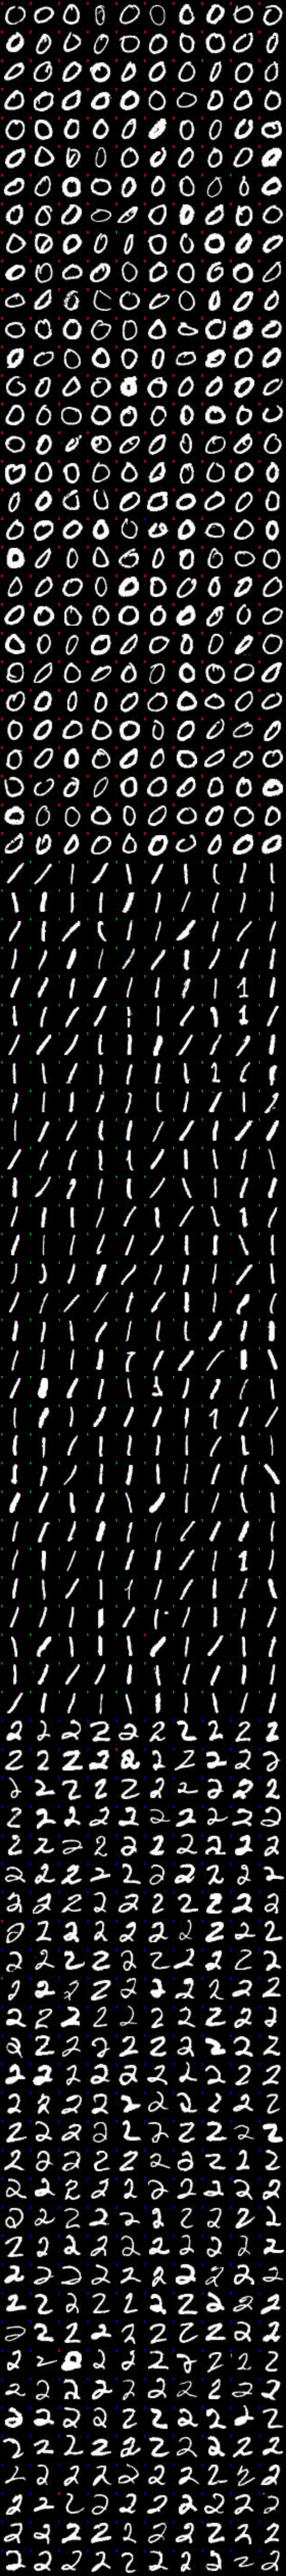

In [60]:
montage = build_montages(images, (128, 128), (10,90))[0]
cv2_imshow(montage)

# **Data Testing Buatan Sendiri**

## **Memasukan Angka 0**

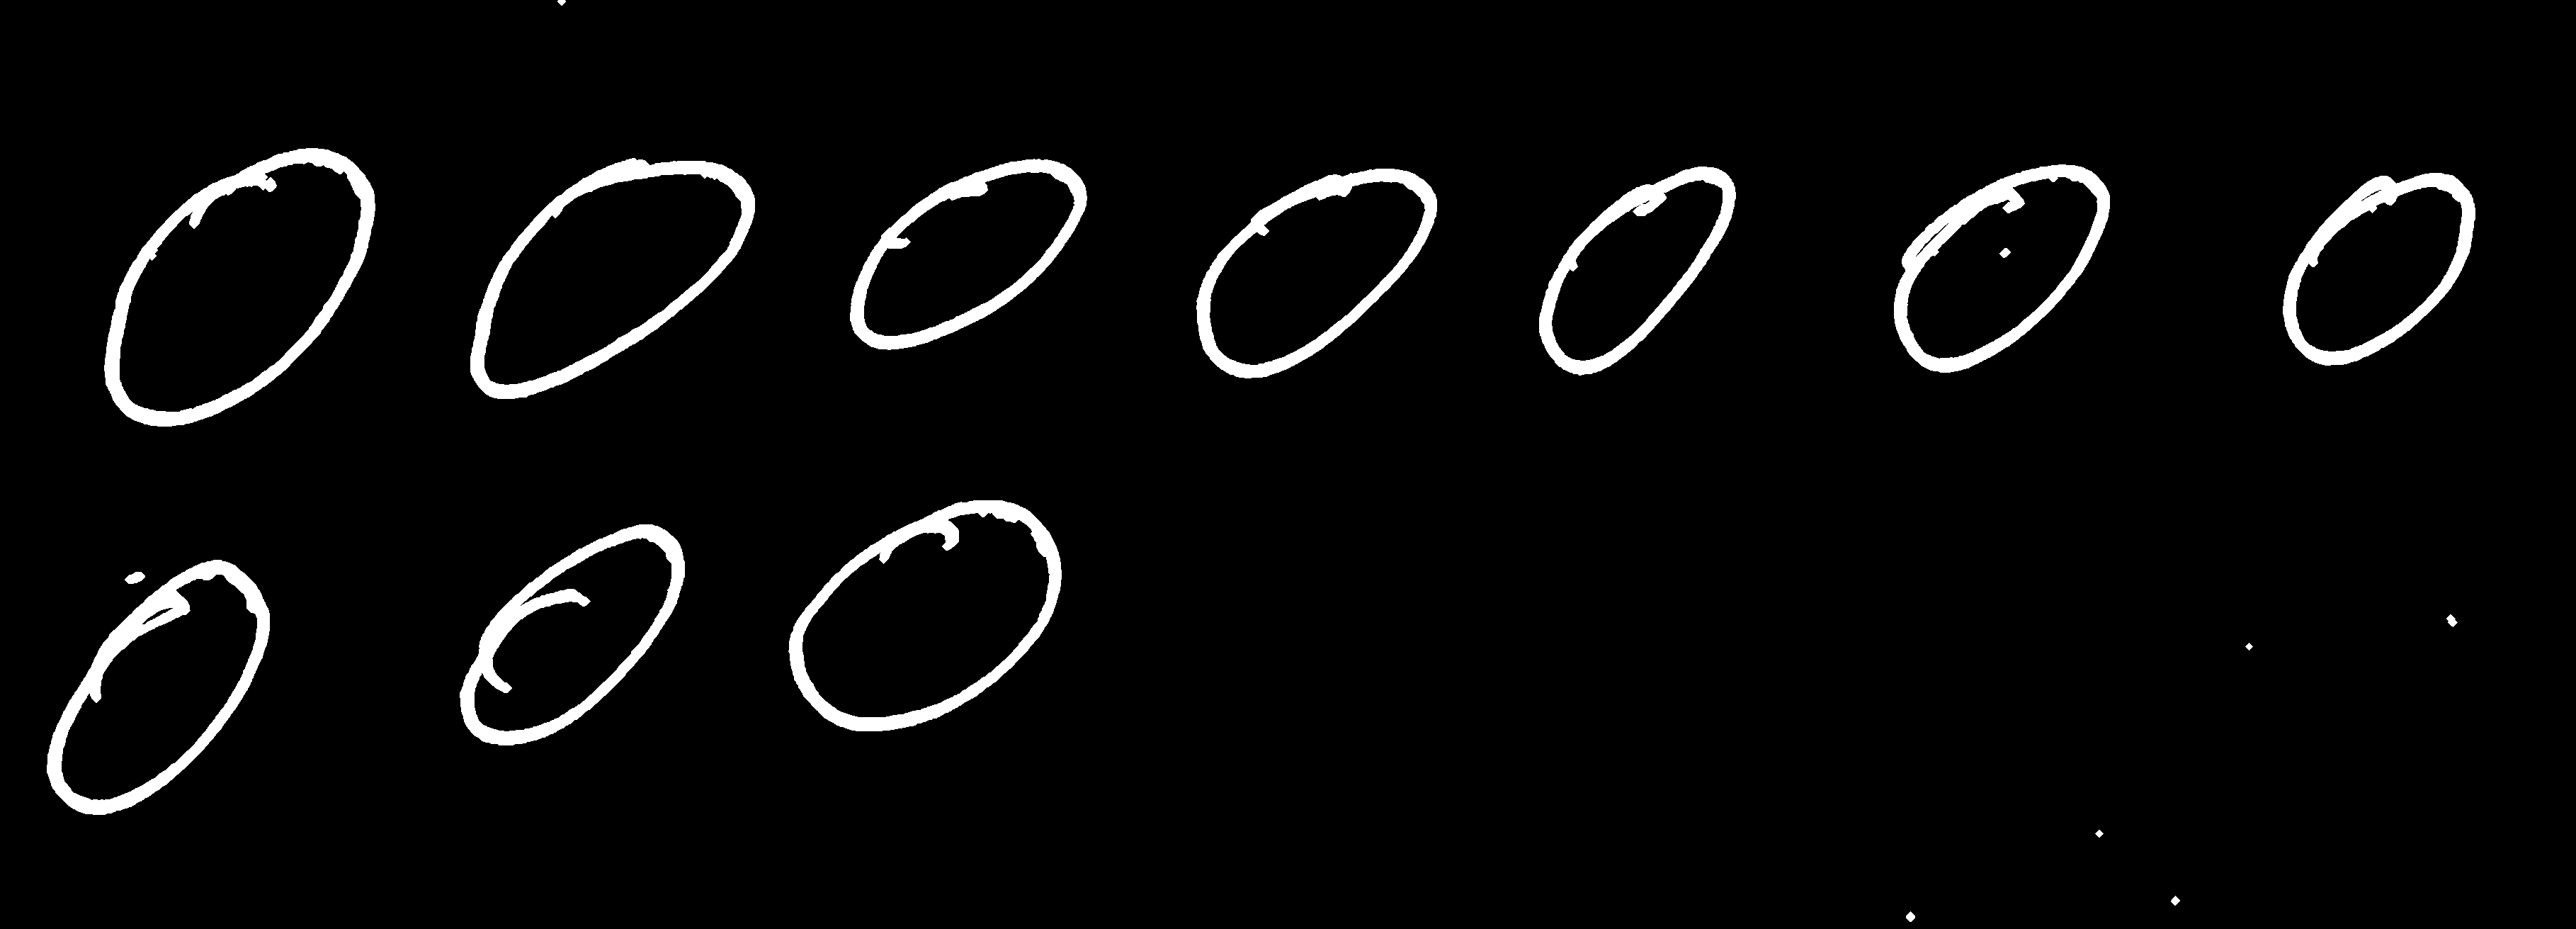

index     area  width  height
15     15  99019.0    383     393
8       8  87104.0    386     326
14     14  84439.0    402     340
6       6  67812.5    315     360
10     10  63620.5    340     296
7       7  58948.0    318     312
12     12  58319.0    305     294
13     13  55671.5    335     270
9       9  50535.0    272     272
11     11  46967.0    278     295
5       5    302.5     29      17
4       4    137.0     16      18
0       0    107.0     13      15
1       1     88.5     13      14
2       2     60.0     12      11
16     16     51.0     12       8
3       3     50.0     11      11

In [67]:
image = cv.imread('/content/drive/My Drive/BCML/foto/number/angka0.png')

def gaus_filter(image,kernel):
  blur = cv.GaussianBlur(image, (kernel, kernel), 0)
  return blur

def filtering_median(image,kernel):
  blur = cv.medianBlur(image, kernel)
  return blur

image_gray = cv.cvtColor(image, cv.COLOR_BGR2GRAY)

image_gray_blur= filtering_median(image_gray,3)

# cv2_imshow(image_gray_blur)

thresholding_value, thresholding_result = cv.threshold(image_gray_blur, 100, 255, cv.THRESH_BINARY)

# print(thresholding_value)
# cv2_imshow(thresholding_result)

thresholding_result = cv.bitwise_not(thresholding_result)
# cv2_imshow(thresholding_result)
kernel = cv.getStructuringElement(cv.MORPH_ELLIPSE, (3,3))
dilation = cv.dilate(thresholding_result,kernel,iterations = 5)
cv2_imshow(dilation)
contours, hierarchy = cv.findContours(dilation, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
# print(contours)

area_array=[]
for index, contour in enumerate(contours):
  x, y, w, h = cv.boundingRect(contour)
  area = cv.contourArea(contour)
  area_array.append([index,area,w,h])
  # print("Contour #" + str(index), x, y, w, h, area)

df_area=pd.DataFrame(area_array)
df_area.columns = ['index','area','width','height']
df_sort=df_area.sort_values(by=['area'],ascending=False)
df_sort.head(50)

In [68]:
test = df_area['area']
array=[]
directory_save = '/content/drive/My Drive/BCML/foto/number/testing_new/0'

for i,v in enumerate(test):
    if test[i] >40000:
      array.append(i)

array.sort()
print(array)
os.chdir(directory_save) 

for i,v in enumerate(array): 
  x, y, w, h = cv.boundingRect(contours[v])
  wave = image[y:y+h, x:x+w]
  # cv2_imshow(wave)
  resized = cv.resize(wave, (28,28), interpolation = cv.INTER_AREA)
  cv.imwrite('angkanol{}.png'.format(i), resized)

print(os.listdir(directory_save))

[6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
['angkanol0.png', 'angkanol1.png', 'angkanol2.png', 'angkanol3.png', 'angkanol4.png', 'angkanol5.png', 'angkanol6.png', 'angkanol7.png', 'angkanol8.png', 'angkanol9.png']


## **Memasukan Angka 1**

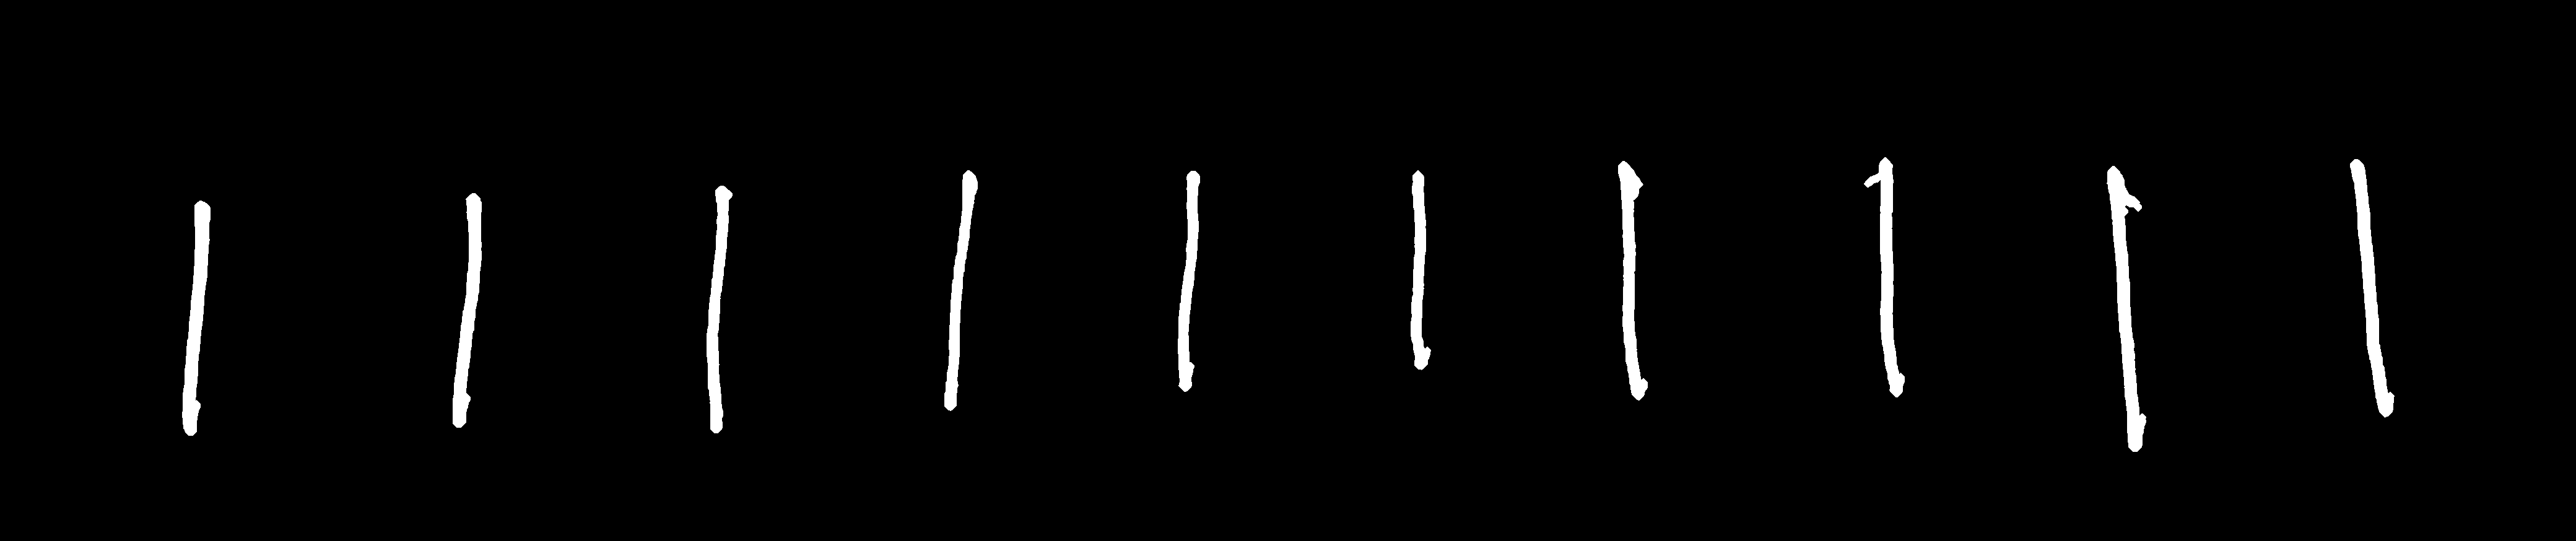

index     area  width  height
6      6  10087.5     64     462
8      8   8328.0     72     418
0      0   8019.5     46     380
9      9   7682.5     66     388
1      1   7630.5     47     379
7      7   7621.0     48     387
2      2   7061.0     42     400
5      5   6517.0     54     389
3      3   6074.5     36     357
4      4   5543.5     33     323

In [69]:
image = cv.imread('/content/drive/My Drive/BCML/foto/number/angka1.png')

def gaus_filter(image,kernel):
  blur = cv.GaussianBlur(image, (kernel, kernel), 0)
  return blur

def filtering_median(image,kernel):
  blur = cv.medianBlur(image, kernel)
  return blur

image_gray = cv.cvtColor(image, cv.COLOR_BGR2GRAY)

image_gray_blur= filtering_median(image_gray,3)

# cv2_imshow(image_gray_blur)

thresholding_value, thresholding_result = cv.threshold(image_gray_blur, 100, 255, cv.THRESH_BINARY)

# print(thresholding_value)
# cv2_imshow(thresholding_result)

thresholding_result = cv.bitwise_not(thresholding_result)
# cv2_imshow(thresholding_result)
kernel = cv.getStructuringElement(cv.MORPH_ELLIPSE, (3,3))
dilation = cv.dilate(thresholding_result,kernel,iterations = 5)
cv2_imshow(dilation)
contours, hierarchy = cv.findContours(dilation, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
# print(contours)

area_array=[]
for index, contour in enumerate(contours):
  x, y, w, h = cv.boundingRect(contour)
  area = cv.contourArea(contour)
  area_array.append([index,area,w,h])
  # print("Contour #" + str(index), x, y, w, h, area)

df_area=pd.DataFrame(area_array)
df_area.columns = ['index','area','width','height']
df_sort=df_area.sort_values(by=['area'],ascending=False)
df_sort.head(50)

In [70]:
test = df_area['area']
array=[]
directory_save = '/content/drive/My Drive/BCML/foto/number/testing_new/1'

for i,v in enumerate(test):
    if test[i] >5000:
      array.append(i)

array.sort()
print(array)
os.chdir(directory_save) 

for i,v in enumerate(array): 
  x, y, w, h = cv.boundingRect(contours[v])
  wave = image[y:y+h, x:x+w]
  # cv2_imshow(wave)
  resized = cv.resize(wave, (28,28), interpolation = cv.INTER_AREA)
  cv.imwrite('angkasatu{}.png'.format(i), resized)

print(os.listdir(directory_save))

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
['angkasatu0.png', 'angkasatu1.png', 'angkasatu2.png', 'angkasatu3.png', 'angkasatu4.png', 'angkasatu5.png', 'angkasatu6.png', 'angkasatu7.png', 'angkasatu8.png', 'angkasatu9.png']


## **Memasukan Angka 2**

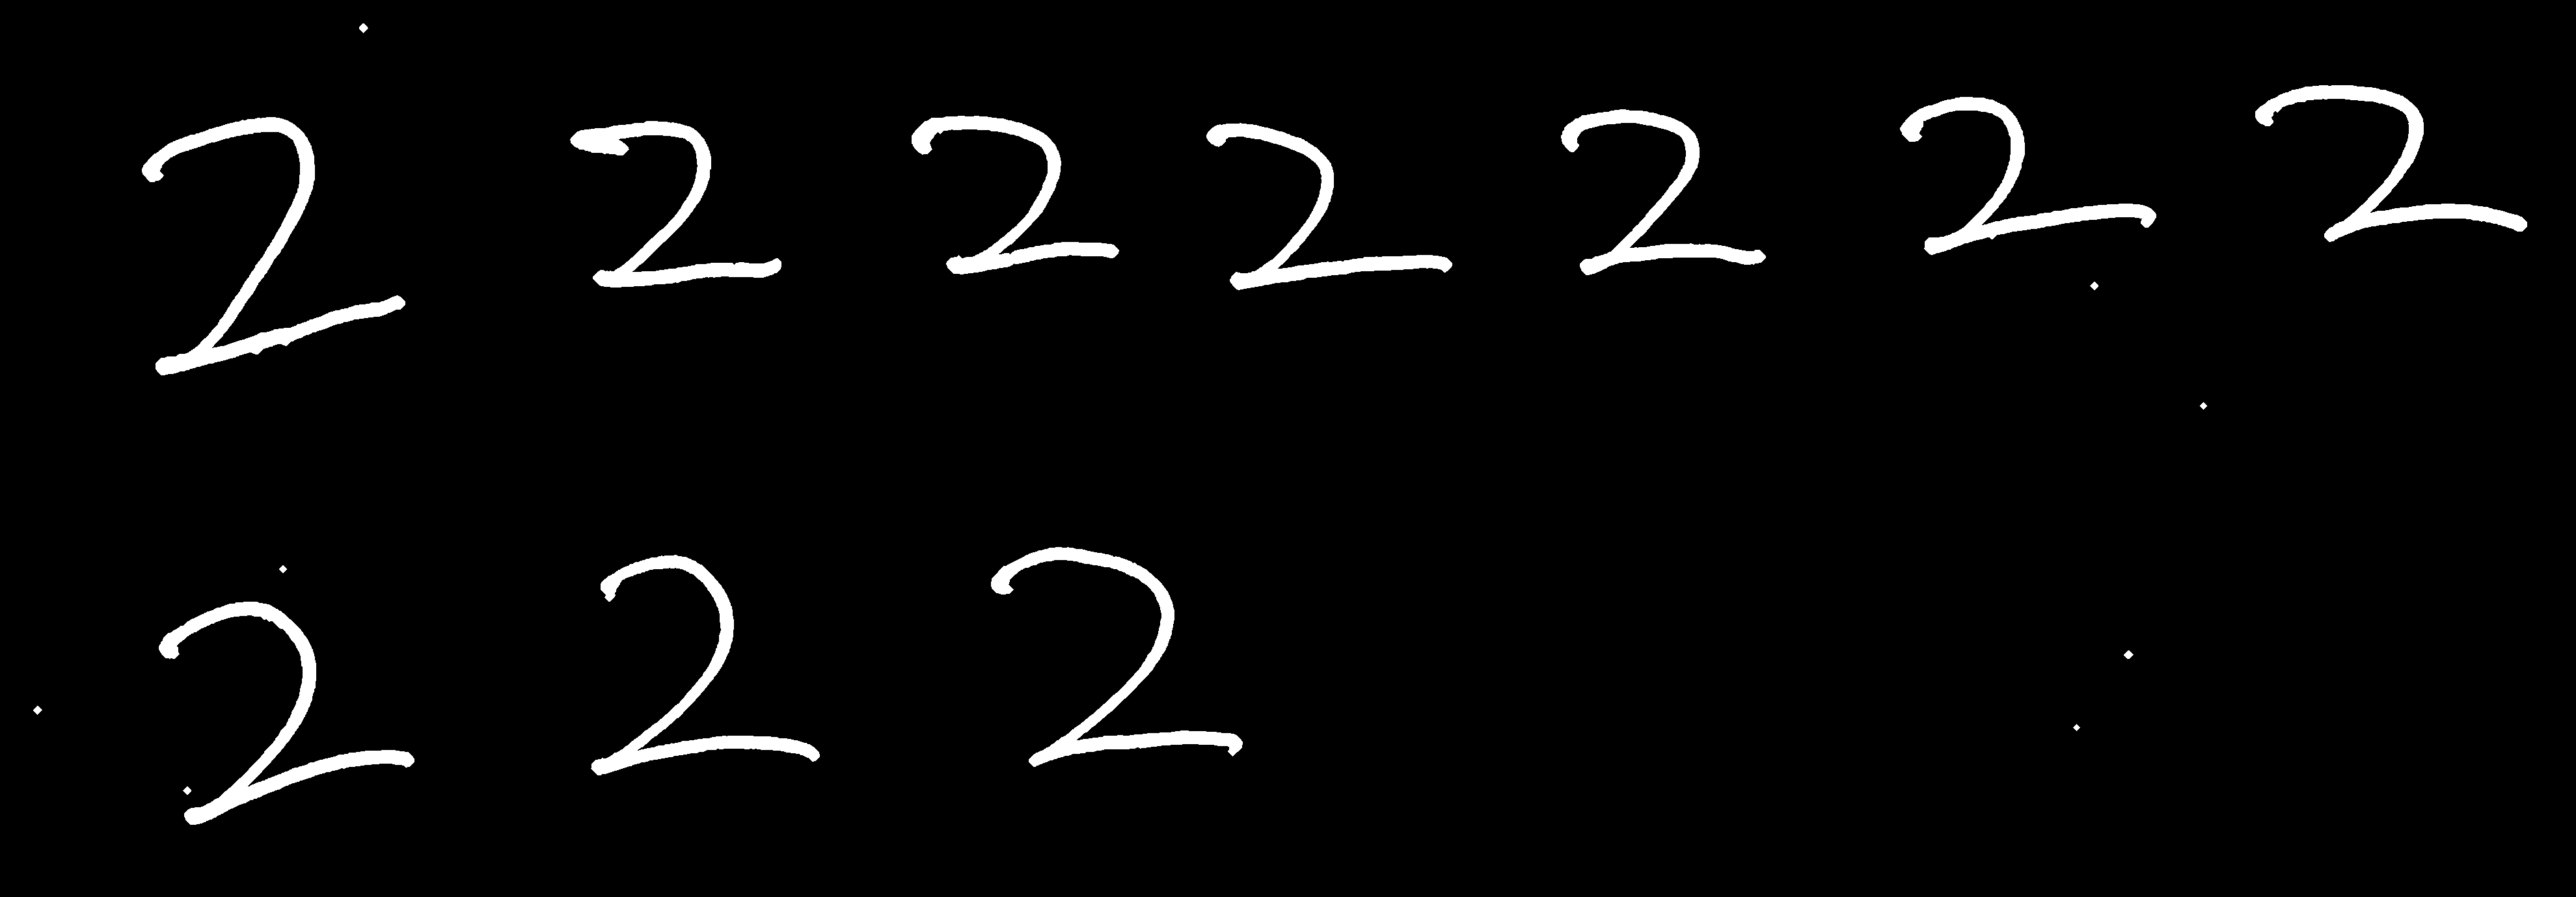

index     area  width  height
12     12  21437.5    405     397
4       4  18038.0    393     343
7       7  17250.5    387     338
6       6  16200.0    352     339
11     11  15744.0    325     256
16     16  15507.5    418     241
15     15  14912.5    394     243
10     10  14235.0    378     257
13     13  13998.5    319     244
14     14  13892.5    315     255
17     17    108.0     14      15
3       3    101.5     15      13
2       2     90.5     14      14
0       0     83.0     13      13
9       9     83.0     13      13
5       5     71.0     12      12
8       8     60.0     11      12
1       1     50.0     11      11

In [71]:
image = cv.imread('/content/drive/My Drive/BCML/foto/number/angka2.png')

def gaus_filter(image,kernel):
  blur = cv.GaussianBlur(image, (kernel, kernel), 0)
  return blur

def filtering_median(image,kernel):
  blur = cv.medianBlur(image, kernel)
  return blur

image_gray = cv.cvtColor(image, cv.COLOR_BGR2GRAY)

image_gray_blur= filtering_median(image_gray,3)

# cv2_imshow(image_gray_blur)

thresholding_value, thresholding_result = cv.threshold(image_gray_blur, 100, 255, cv.THRESH_BINARY)

# print(thresholding_value)
# cv2_imshow(thresholding_result)

thresholding_result = cv.bitwise_not(thresholding_result)
# cv2_imshow(thresholding_result)
kernel = cv.getStructuringElement(cv.MORPH_ELLIPSE, (3,3))
dilation = cv.dilate(thresholding_result,kernel,iterations = 5)
cv2_imshow(dilation)
contours, hierarchy = cv.findContours(dilation, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
# print(contours)

area_array=[]
for index, contour in enumerate(contours):
  x, y, w, h = cv.boundingRect(contour)
  area = cv.contourArea(contour)
  area_array.append([index,area,w,h])
  # print("Contour #" + str(index), x, y, w, h, area)

df_area=pd.DataFrame(area_array)
df_area.columns = ['index','area','width','height']
df_sort=df_area.sort_values(by=['area'],ascending=False)
df_sort.head(50)

In [72]:
test = df_area['area']
array=[]
directory_save = '/content/drive/My Drive/BCML/foto/number/testing_new/2'

for i,v in enumerate(test):
    if test[i] >13000:
      array.append(i)

array.sort()
print(array)
os.chdir(directory_save) 

for i,v in enumerate(array): 
  x, y, w, h = cv.boundingRect(contours[v])
  wave = image[y:y+h, x:x+w]
  # cv2_imshow(wave)
  resized = cv.resize(wave, (28,28), interpolation = cv.INTER_AREA)
  cv.imwrite('angkadua{}.png'.format(i), resized)

print(os.listdir(directory_save))

[4, 6, 7, 10, 11, 12, 13, 14, 15, 16]
['angkadua0.png', 'angkadua1.png', 'angkadua2.png', 'angkadua3.png', 'angkadua4.png', 'angkadua5.png', 'angkadua6.png', 'angkadua7.png', 'angkadua8.png', 'angkadua9.png']


## **Coba Algoritma Dengan Data baru**

In [76]:
dataset_dir = '/content/drive/My Drive/BCML/foto/number'
testingPath = os.path.join(dataset_dir, "testing_new")

testing_paths = list(paths.list_images(testingPath))
images = []
svc_class = SVC(kernel='rbf')
svc_class.fit(feature_train, label_train)
labeltest=[]

for testing_path in testing_paths[:]:
  image = cv.imread(testing_path)
  output = image.copy()
  output = cv.resize(output, (128, 128))

  image = preprocess(image, image_size=resize_image_size)

  if extraction_method == 'hog':
	  features = quantify_image_hog(image)
  elif extraction_method == 'lbp':
	  features = quantify_image_lbp(image)
   
  preds = svc_class.predict([features])
  label = le.inverse_transform(preds)[0]
  labeltest.append(label)
	# color = (0, 255, 0) if label == "1" else (0, 0, 255)
  if label=='0':  
    color=(0,0,255)
  elif label=='1': 
    color=(0,255,0)
  elif label=='2':
    color=(255,0,0)
  cv.putText(output, label, (3, 20), cv.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)
  images.append(output)

In [77]:
print(len(labeltest))

30


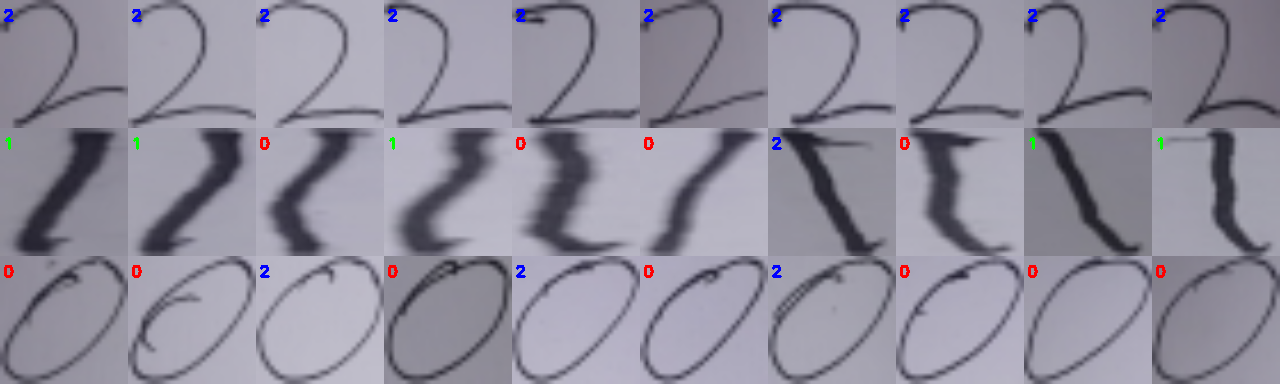

In [78]:
montage = build_montages(images, (128, 128), (10,3))[0]
cv2_imshow(montage)

berdasarkan hasil uji coba dengan data sendiri hasil yang di dapat akurasi sekitar 73% (perhitungan sendiri dengan melihat yang benar) ini dapat terjadi karena ketika resize pixel-pixel yang ada pada gambar ikut rusak jadi data yang ada pada gambar ikut rusak. ini mebuktikan kualitas data sangat mempengaruhi tingkat akurasi.